# Check the classes and how many videos inside

In [1]:
# ! pip install jupyter notebook
# ! pip install zipfile36  
# ! pip install tqdm
# ! pip install pathlib  
# ! pip install opencv-python
# ! pip install numpy
# ! pip install remotezip
# ! pip install imageio
# ! pip install ipython
# ! pip install tensorflow
# ! pip install tensorflow-docs

In [2]:
# import tqdm
import random
import pathlib
import itertools
import collections
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
from collections import defaultdict

In [3]:


def create_video_dict(folder_path='videos_3'):
    # Step 1: Initialize the dictionary to store classes and their videos
    video_dict = defaultdict(list)
    
    # Step 2: Iterate through the folder structure
    for root, dirs, files in os.walk(folder_path):
        if root != folder_path:  # Skip the root level
            class_name = os.path.basename(root)
            # Add video files to the list for each class
            video_files = [os.path.join(root, f) for f in files if f.endswith(('.mp4', '.avi', '.mov'))]
            video_dict[class_name].extend(video_files)
    
    return video_dict

# Generate the video_dict
video_dict = create_video_dict()

# Display the output
print("Dictionary of classes and their video paths:")
for class_name, videos in video_dict.items():
    print(f"{class_name}:")
    for video in videos:
        print(f"  - {video}")



Dictionary of classes and their video paths:
book:
  - videos_3\book\07068.mp4
  - videos_3\book\07069.mp4
  - videos_3\book\07070.mp4
  - videos_3\book\07071.mp4
  - videos_3\book\07072.mp4
  - videos_3\book\07073.mp4
  - videos_3\book\07074.mp4
  - videos_3\book\07075.mp4
  - videos_3\book\07076.mp4
  - videos_3\book\07077.mp4
  - videos_3\book\07078.mp4
  - videos_3\book\07079.mp4
  - videos_3\book\07080.mp4
  - videos_3\book\07081.mp4
  - videos_3\book\07082.mp4
  - videos_3\book\07083.mp4
  - videos_3\book\07084.mp4
  - videos_3\book\07085.mp4
  - videos_3\book\07086.mp4
  - videos_3\book\07087.mp4
  - videos_3\book\07088.mp4
  - videos_3\book\07089.mp4
  - videos_3\book\07090.mp4
  - videos_3\book\07091.mp4
  - videos_3\book\07092.mp4
  - videos_3\book\07093.mp4
  - videos_3\book\07094.mp4
  - videos_3\book\07095.mp4
  - videos_3\book\07096.mp4
  - videos_3\book\07097.mp4
  - videos_3\book\07098.mp4
  - videos_3\book\07099.mp4
  - videos_3\book\65225.mp4
  - videos_3\book\67424.m

In [4]:
import tensorflow as tf
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt

# Normalization function
def normalize(frames, labels):
    frames = tf.cast(frames, tf.float32) / 255.0
    return frames, labels

# Augmentation function (for training only)
def augment_frames(frames, labels):
    augmented_frames = []
    for frame in frames:
        # Random horizontal flip
        frame = tf.image.random_flip_left_right(frame)
        
        # Center crop to 90% of the original size, then resize back to 224x224
        frame = tf.image.central_crop(frame, central_fraction=0.9)
        frame = tf.image.resize(frame, (224, 224))
        
        # Random crop to a smaller area then resize back to 224x224
        frame = tf.image.resize_with_crop_or_pad(frame, 250, 250)
        frame = tf.image.random_crop(frame, size=[224, 224, 1])
        
        # Random rotation by a small angle (uncomment if using tfa)
        # degrees = tf.random.uniform([], minval=-10, maxval=10, dtype=tf.float32)
        # frame = tfa.image.rotate(frame, degrees * 3.14159 / 180)
        
        augmented_frames.append(frame)
    augmented_frames = tf.stack(augmented_frames)
    return augmented_frames, labels

In [5]:
def split_train_test(video_dict, train_ratio=0.8):
    # Initialize dictionaries for training and testing subsets
    train_dict = defaultdict(list)
    test_dict = defaultdict(list)

    for class_name, videos in video_dict.items():
        # Shuffle videos to ensure randomness
        random.shuffle(videos)
        # Determine split point
        split_index = int(len(videos) * train_ratio)
        
        # Split videos into train and test lists
        train_dict[class_name] = videos[:split_index]
        test_dict[class_name] = videos[split_index:]
    
    return train_dict, test_dict

# Split the video_dict into train and test sets
train_dict, test_dict = split_train_test(video_dict)

print("Training Set:")
for class_name, videos in train_dict.items():
    print(f"{class_name}: {len(videos)} videos")

print("\nTesting Set:")
for class_name, videos in test_dict.items():
    print(f"{class_name}: {len(videos)} videos")



Training Set:
book: 32 videos
computer: 24 videos
drink: 28 videos

Testing Set:
book: 8 videos
computer: 6 videos
drink: 7 videos


# Create a frame for each video file

In [6]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [7]:
import cv2
import numpy as np
import random

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Creates frames from each video file present for each category.

    Args:
        video_path: File path to the video.
        n_frames: Number of frames to be created per video file.
        output_size: Pixel size of the output frame image.

    Returns:
        A NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length  # Ensure max_start is an integer
        start = random.randint(0, max_start)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    for _ in range(n_frames):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            # Convert to grayscale
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Resize frame to output size (only height and width)
            frame = cv2.resize(frame, output_size[:2])  # Only take height and width

            # Add channel dimension for grayscale
            frame = np.expand_dims(frame, axis=-1)  # Make it (height, width, 1)
            result.append(frame)
        else:
            # Add a consistent zero frame if read fails, matching the output size.
            zero_frame = np.zeros((*output_size[:2], 1), dtype=np.uint8)  # Ensure it's (height, width, 1)
            result.append(zero_frame)

    src.release()
    result = np.array(result)

    return result




Processing class 'book' with 40 videos.
Processing video: videos_3\book\68208.mp4


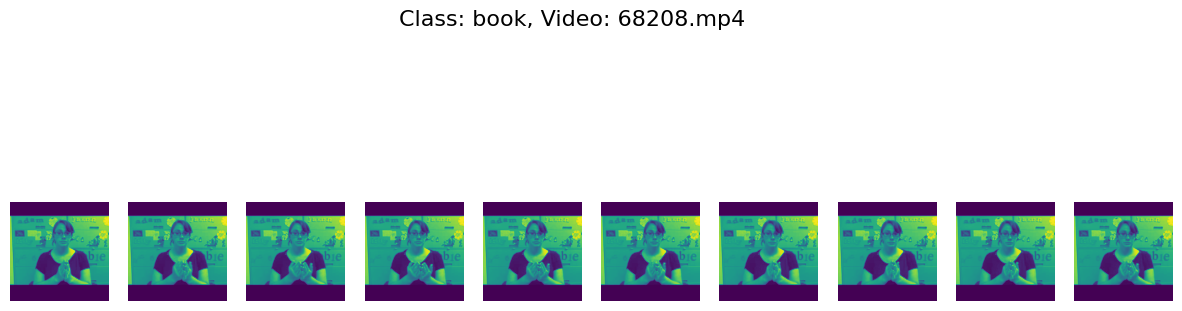

NameError: name 'augmented_frames' is not defined

In [8]:
import random
import matplotlib.pyplot as plt

def process_videos_from_dict(video_dict, n_frames=10, output_size=(224,224), frame_step=1, samples_per_class=2):
    """
    Processes each video in video_dict, generates frames, and visualizes random samples.
    
    Args:
        video_dict (dict): Dictionary containing classes as keys and lists of video paths as values.
        n_frames (int): Number of frames to extract per video.
        output_size (tuple): Desired output frame size.
        frame_step (int): Step size for frames.
        samples_per_class (int): Number of random samples to visualize per class.
    """
    for class_name, video_paths in video_dict.items():
        print(f"\nProcessing class '{class_name}' with {len(video_paths)} videos.")

        # Sample random videos from each class
        sample_videos = random.sample(video_paths, min(samples_per_class, len(video_paths)))
        
        for video_path in sample_videos:
            print(f"Processing video: {video_path}")
            frames = frames_from_video_file(video_path, n_frames, output_size, frame_step)

            # Normalize the frames
            normalized_frames, labels = normalize(frames, class_name)

            # Perform data augmentation (if you are in training phase)
            # augmented_frames, _ = augment_frames(normalized_frames, labels)


            visualize_frames(normalized_frames, class_name, video_path)
            visualize_frames(augmented_frames, class_name, video_path)


def visualize_frames(frames, class_name, video_name):
    """
    Visualizes frames in a grid for a given video.
    
    Args:
        frames (np.array): Array of frames to visualize.
        class_name (str): Name of the class.
        video_name (str): Name of the video file.
    """
    plt.figure(figsize=(15, 5))
    n_frames = frames.shape[0]
    grid_size = min(10, n_frames)  # Show up to 5 frames

    for i in range(grid_size):
        plt.subplot(1, grid_size, i + 1)
        plt.imshow(frames[i])
        plt.axis("off")

    plt.suptitle(f"Class: {class_name}, Video: {os.path.basename(video_name)}", fontsize=16)
    plt.show()

# Run the function on video_dict
process_videos_from_dict(video_dict, n_frames=10, output_size=(224,224), frame_step=1, samples_per_class=2)


# Visualize video data

In [ ]:
import random
import tensorflow as tf

class FrameGenerator:
    def __init__(self, video_dict, n_frames, training=False):
        self.video_dict = video_dict
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(self.video_dict.keys())
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        video_paths = []
        classes = []
        for class_name, videos in self.video_dict.items():
            video_paths.extend(videos)
            classes.extend([class_name] * len(videos))
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = tf.one_hot(self.class_ids_for_name[name], depth=len(self.class_names))
            yield video_frames, label


In [ ]:
# Initialize FrameGenerator for the training data directly with the dictionary
train_fg = FrameGenerator(train_dict, n_frames=10, training=True)

# Test FrameGenerator by retrieving a batch of frames and label
frames, label = next(train_fg())

# Display the shape of the frames and the label to verify
print(f"Shape of frames: {frames.shape}")  # Expected shape: (10, height, width, channels)
print(f"Label (one-hot encoded): {label}")


Shape of frames: (10, 224, 224, 1)
Label (one-hot encoded): [1. 0. 0.]


In [ ]:
# Define output signature for frames and labels
output_signature = (
    tf.TensorSpec(shape=(10, 224, 224,1), dtype=tf.float32),  # Adjust if needed
    tf.TensorSpec(shape=(3,), dtype=tf.float32)  # Assuming 3 classes for one-hot encoding
)

# Create the training dataset
train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(train_dict, n_frames=10, training=True),
    output_signature=output_signature
)

# Check that labels are shuffled
print("Sample labels from training dataset to verify shuffling:")
for frames, labels in train_ds.take(10):
    print(labels)

# Create the validation dataset (no shuffling needed)
val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(test_dict, n_frames=10, training=False),
    output_signature=output_signature
)

# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')


Sample labels from training dataset to verify shuffling:
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
Shape of training set of frames: (10, 224, 224, 1)
Shape of training labels: (3,)
Shape of validation set of frames: (10, 224, 224, 1)
Shape of validation labels: (3,)


# The 3D CNN training model set up

In [ ]:
import tensorflow as tf

# Define the 3D CNN model with global pooling at the end
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(10, 224, 224, 1)),
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
    # Replacing MaxPooling3D with GlobalAveragePooling3D to avoid dimension issues
    tf.keras.layers.GlobalAveragePooling3D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_dict.keys()), activation='softmax')  # Adjust to the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy' if labels are integer-encoded
    metrics=['accuracy']
)

# Model summary to verify
model.summary()

c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 8, 222, 222,    │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 8, 111, 111,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 111, 111,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 6, 109, 109,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 3, 54, 54, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 54, 54, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 1, 52, 52, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,747 (1.19 MB)

 Trainable params: 311,555 (1.19 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Ensure train_ds and val_ds are batched properly
train_ds = train_ds.batch(8).prefetch(tf.data.AUTOTUNE)  
val_ds = val_ds.batch(8).prefetch(tf.data.AUTOTUNE)


In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True)]
)


Epoch 1/10
     11/Unknown 21s 2s/step - accuracy: 0.2795 - loss: 1.3136

c:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.2780 - loss: 1.3120 - val_accuracy: 0.3810 - val_loss: 1.2971
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3907 - loss: 1.2231 - val_accuracy: 0.4286 - val_loss: 0.9456
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4043 - loss: 1.0742 - val_accuracy: 0.6667 - val_loss: 0.9436
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6392 - loss: 0.8784 - val_accuracy: 0.5714 - val_loss: 1.2561
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5430 - loss: 0.9293 - val_accuracy: 0.5714 - val_loss: 1.1663


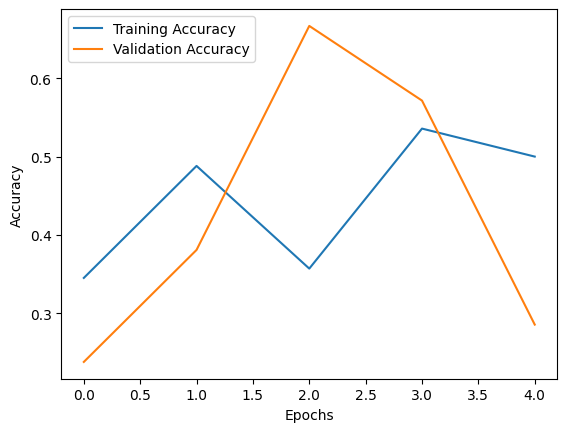

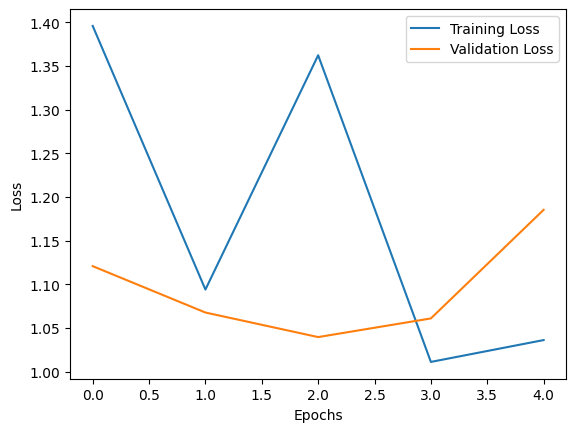

In [ ]:
# Visualize Training and Validation Metrics
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the validation or test dataset

# Calculate the number of validation steps
validation_steps = int(tf.data.experimental.cardinality(val_ds).numpy())
print(validation_steps)

test_loss, test_accuracy = model.evaluate(val_ds, steps=validation_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


-2


ValueError: math domain error

In [ ]:
import numpy as np

# Fetch a batch of data from the validation set
for frames, labels in val_ds.take(1):
    predictions = model.predict(frames)
    predicted_classes = np.argmax(predictions, axis=-1)
    true_classes = np.argmax(labels, axis=-1)
    print("Predicted classes:", predicted_classes)
    print("True classes:", true_classes)
